# Сборный проект —2
**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

- **Задача 1** — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

- **Задача 2** — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача 1: предсказание уровня удовлетворённости сотрудника

**Описание данных:**

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, **целевой признак**.

In [ ]:
!pip install -U scikit-learn -q
!pip install phik -q
#!pip install optuna -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
#import shap
import phik
import scipy.stats as st
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import GridSearchCV #, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression #, Ridge
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score
#, r2_score, accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler #, LabelEncoder
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#from sklearn.svm import SVC
#from optuna.integration import OptunaSearchCV
from sklearn.dummy import DummyClassifier
#from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
sklearn.__version__

'1.3.2'

### Загрузка данных

- Тренировочная выборка: `train_job_satisfaction_rate.csv`
- Входные признаки тестовой выборки: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

In [ ]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    train_job_satisfaction_rate = pd.read_csv('C:/Users/Student/Desktop/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('C:/Users/Student/Desktop/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('C:/Users/Student/Desktop/test_target_job_satisfaction_rate.csv')

In [ ]:
def dfinfo(df):
    df.info()
    display(df.head())

dfinfo(train_job_satisfaction_rate)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [ ]:
dfinfo(test_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
dfinfo(test_target_job_satisfaction_rate)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


В датасете `train_job_satisfaction_rate` 4000 строк, в `test_features` и `test_target_job_satisfaction_rate` по 2000 строк.

В `train_job_satisfaction_rate`, `test_features` есть пропуски в столбцах `dept` и `level`, в `test_target_job_satisfaction_rate` пропусков нет.

В  `test_features` (входные признаки тестовой выборки) и `test_target_job_satisfaction_rate` (целевой признак тестовой выборки) сотрудники идут в разном порядке, т.е. пользоваться тестовой выборкой "как есть" не получится, надо будет присоединять целевой к входным по id и заново делить.

### Предобработка  данных

- Изучить данные и сделать выводы.
- При необходимости выполнить предобработку.
- Если есть пропуски, заполнить их в пайплайне.

Заполним найденные пропуски значением "unknown", поскольку это реальные работники, просто для них не указаны название отдела и уровень должности, а все остальные признаки есть.

In [ ]:
def predobr(df):

    df_columns = df.columns
    cat_columns = df.select_dtypes(include='object').columns

    data_preprocessor = ColumnTransformer(
        [
            ('simput_cat', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown'), cat_columns),
        ],
        remainder='passthrough') # verbose_feature_names_out=False)

    df[cat_columns] = data_preprocessor.fit_transform(df[cat_columns])
    df = pd.DataFrame(df, columns = df_columns) # data_preprocessor.feature_names_in_)

    print('Пропуски:')
    print(df.isna().sum())
    print('Дубликатов', df.duplicated().sum())
    if df.duplicated().sum()>0:
        df = df.drop_duplicates().reset_index(drop=True)
        print('Дубликатов после удаления', df.duplicated().sum())
    #display(df[df.isna().any(axis=1)])
    for col in cat_columns:
        print(f'Уникальные значения "{col}":', df[col].sort_values().unique())

In [ ]:
predobr(train_job_satisfaction_rate)

Пропуски:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Дубликатов 0
Уникальные значения "dept": ['hr' 'marketing' 'purchasing' 'sales' 'technology' 'unknown']
Уникальные значения "level": ['junior' 'middle' 'sinior' 'unknown']
Уникальные значения "workload": ['high' 'low' 'medium']
Уникальные значения "last_year_promo": ['no' 'yes']
Уникальные значения "last_year_violations": ['no' 'yes']


In [ ]:
predobr(test_features)

Пропуски:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Дубликатов 0
Уникальные значения "dept": [' ' 'hr' 'marketing' 'purchasing' 'sales' 'technology' 'unknown']
Уникальные значения "level": ['junior' 'middle' 'sinior' 'unknown']
Уникальные значения "workload": [' ' 'high' 'low' 'medium']
Уникальные значения "last_year_promo": ['no' 'yes']
Уникальные значения "last_year_violations": ['no' 'yes']


In [ ]:
predobr(test_target_job_satisfaction_rate)

Пропуски:
id                       0
job_satisfaction_rate    0
dtype: int64
Дубликатов 0


В датасете `test_features` есть пустые значения (не пропуски, а пробелы) в названии отдела, уровне загруженности, их тоже заменим на "unknown", т.к. все остальные признаки есть.

In [ ]:
test_features.query('dept==" " or workload==" "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


In [ ]:
test_target_job_satisfaction_rate.query('id==590867 or id==822186')

,id,job_satisfaction_rate
281,590867,0.79
344,822186,0.64


In [ ]:
test_features['dept'] = test_features['dept'].str.replace(' ', 'unknown')
test_features['dept'].sort_values().unique()

array(['hr', 'marketing', 'purchasing', 'sales', 'technology', 'unknown'],
      dtype=object)

In [ ]:
test_features['workload'] = test_features['workload'].str.replace(' ', 'unknown')
test_features['workload'].sort_values().unique()

array(['high', 'low', 'medium', 'unknown'], dtype=object)

Мы заполнили пропуски в названии отдела и уровне должности значением "unknown", для этого в функцию предобработки включили пайплайн.

Явных и неявных дубликатов нет. Переименовывать столбцы, менять типы данных не нужно.

В датасете `test_features` пробелы в названии отдела и уровне загруженности заменили на "unknown".

### Исследовательский анализ  данных

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


Сравним распределение количественных признаков 
в тренировочной и тестовой выборках:


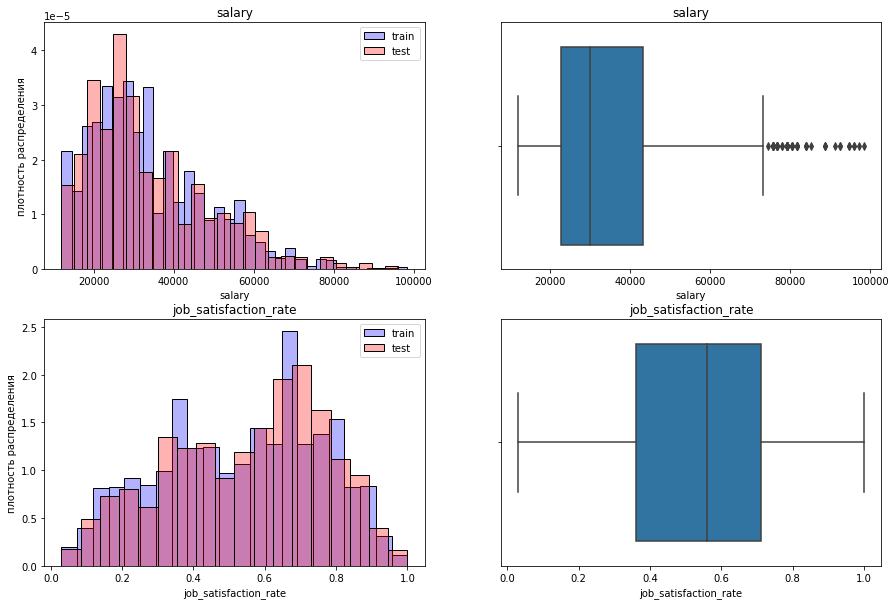

In [ ]:
def issl_analiz2(df, df2, x, list_col = []):
    display(df.describe())

    print('Сравним распределение количественных признаков \nв тренировочной и тестовой выборках:')

    if list_col == []:
        list_col = df.select_dtypes(exclude='object').columns
    if len(list_col)>1:
        fig,axes = plt.subplots(nrows=len(list_col), ncols=2, figsize=(15, x))
        i=0
        for col in list_col:
            sns.histplot(stat='density', common_norm=False, data=df, x=col, ax=axes[i][0], alpha=0.3, label='train',
                         color='blue', legend=True) #.set(title=col)
            sns.histplot(stat='density', common_norm=False, data=df2, x=col, ax=axes[i][0], alpha=0.3, label='test',
                         color='red', legend=True).set(title=col, ylabel='плотность распределения', xlabel=col)
            axes[i][0].legend(['train', 'test'])

            #df[col].plot(kind='hist', x=col, ax=axes[i][0], title=col, bins=50, alpha=0.7, label='train', legend=True)

            sns.boxplot(x=col, data=df, ax=axes[i][1]).set(title=col)
            i+=1
    else:
        fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(15, x))
        for col in list_col:
            sns.histplot(stat='density', common_norm=False, data=df, x=col, ax=axes[0], alpha=0.3, label='train',
                         color='blue') #, legend=True) #.set(title=col)
            sns.histplot(stat='density', common_norm=False, data=df2, x=col, ax=axes[0], alpha=0.3, label='test',
                         color='red').set(title=col, ylabel='плотность распределения', xlabel=col)
            axes[0].legend(['train', 'test'])
            sns.boxplot(x=col, data=df, ax=axes[1]).set(title=col)

plt.show()

issl_analiz2(train_job_satisfaction_rate.drop('id', axis=1), test_features.merge(test_target_job_satisfaction_rate,
                                on='id', how='left').drop('id', axis=1), 10, ['salary', 'job_satisfaction_rate'])

Распределение в тренировочной и тестовой выборках практически одинаковое:

- зарплата - "многопиковое" нормальное распределение с большим правым хвостом (большая зарплата у единиц, что логично);
- удовлетворённость работой - 2 пика (с провалами), или нормальное с провалом посередине (сотрудники довольны либо на примерно 0.4, либо на примерно 0.7, сомневающихся мало).

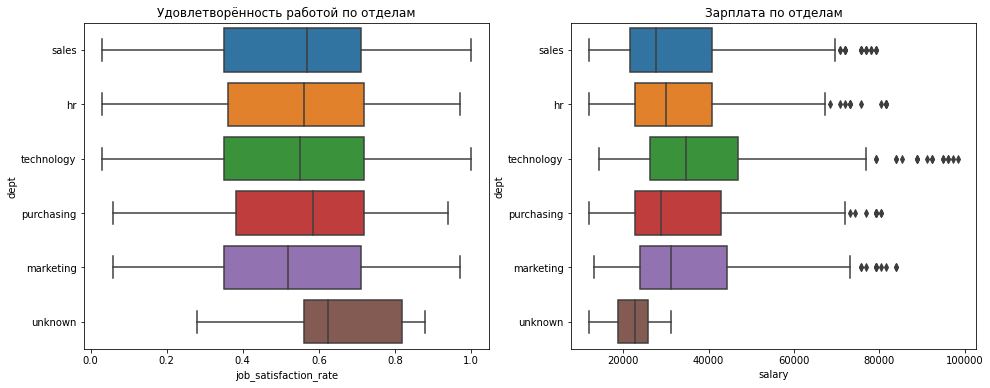

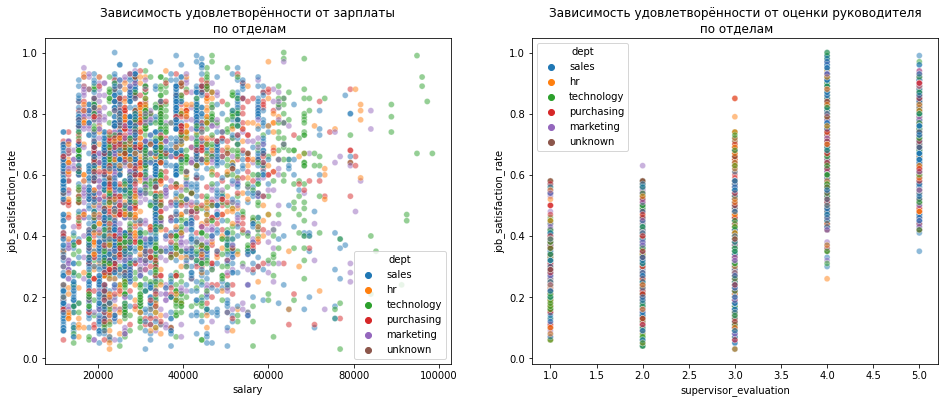

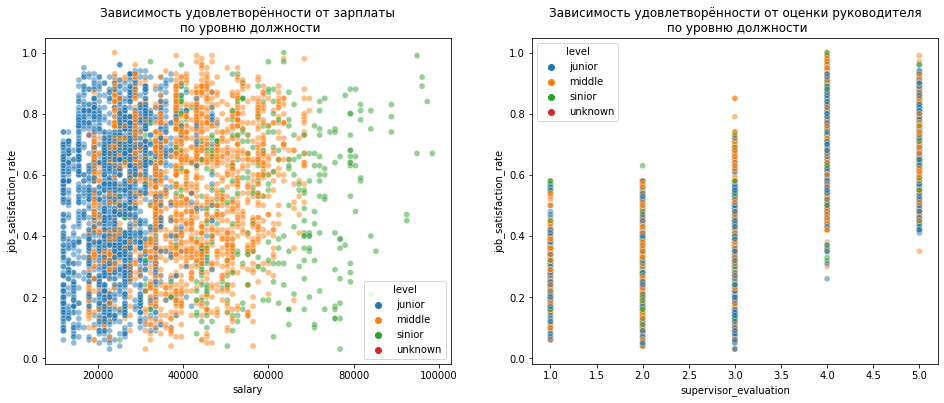

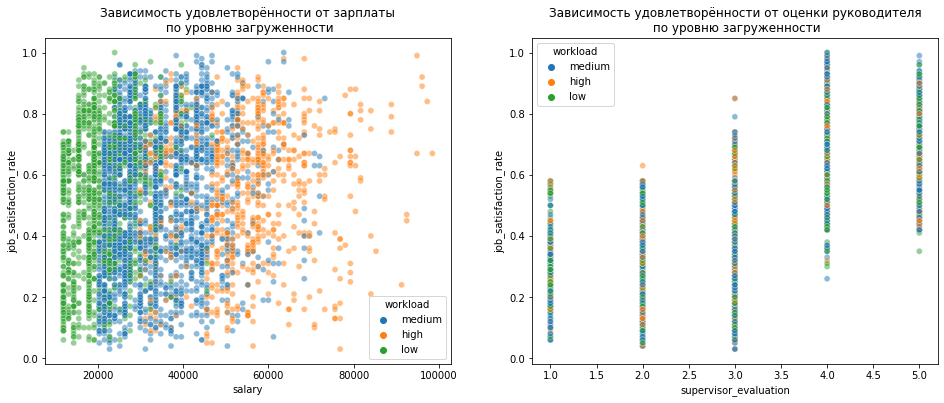

In [ ]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.boxplot(x='job_satisfaction_rate', y='dept', data=train_job_satisfaction_rate, ax=axes[0]).set(title=
                                                                                    'Удовлетворённость работой по отделам')
sns.boxplot(x='salary', y='dept', data=train_job_satisfaction_rate, ax=axes[1]).set(title='Зарплата по отделам')
plt.show()

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.scatterplot(data=train_job_satisfaction_rate, x='salary', y='job_satisfaction_rate', hue='dept', alpha=0.5,
                ax=axes[0]).set(title='Зависимость удовлетворённости от зарплаты\n по отделам')
sns.scatterplot(data=train_job_satisfaction_rate, x='supervisor_evaluation', y='job_satisfaction_rate', hue='dept', alpha=0.5,
                ax=axes[1]).set(title='Зависимость удовлетворённости от оценки руководителя\n по отделам')
plt.show()

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.scatterplot(data=train_job_satisfaction_rate, x='salary', y='job_satisfaction_rate', hue='level', alpha=0.5,
                ax=axes[0]).set(title='Зависимость удовлетворённости от зарплаты\n по уровню должности')
sns.scatterplot(data=train_job_satisfaction_rate, x='supervisor_evaluation', y='job_satisfaction_rate', hue='level', alpha=0.5,
                ax=axes[1]).set(title='Зависимость удовлетворённости от оценки руководителя\n по уровню должности')
plt.show()

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.scatterplot(data=train_job_satisfaction_rate, x='salary', y='job_satisfaction_rate', hue='workload', alpha=0.5,
                ax=axes[0]).set(title='Зависимость удовлетворённости от зарплаты\n по уровню загруженности')
sns.scatterplot(data=train_job_satisfaction_rate, x='supervisor_evaluation', y='job_satisfaction_rate', hue='workload', alpha=0.5,
                ax=axes[1]).set(title='Зависимость удовлетворённости от оценки руководителя\n по уровню загруженности')
plt.show()

In [ ]:
def issl_analiz_cat(df, x, list_cat=[]):
    if list_cat == []:
        list_cat = df.select_dtypes(include='object').columns
    if len(list_cat)%2==0:
        n = len(list_cat)/2
    else:
        n = len(list_cat)//2+1

    if n>1:
        fig,axes = plt.subplots(nrows=int(n), ncols=2, figsize=(12, x)) #
        i=0
        j=0
        for col in list_cat:
            df.pivot_table(index=col, aggfunc='count').plot(kind='pie', y='id', autopct='%1.1f%%',
                    legend=False, xlabel=col, ylabel='', title=f'Распределение по признаку "{col}"', ax=axes[i][j])
            if j==1:
                j-=1
                i+=1
            else:
                j+=1
    else:
        fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12, x)) #
        i=0
        for col in list_cat:
            df.pivot_table(index=col, aggfunc='count').plot(kind='pie', y='id', autopct='%1.1f%%',
                    legend=False, xlabel=col, ylabel='', title=f'Распределение по признаку "{col}"', ax=axes[i])
            i+=1

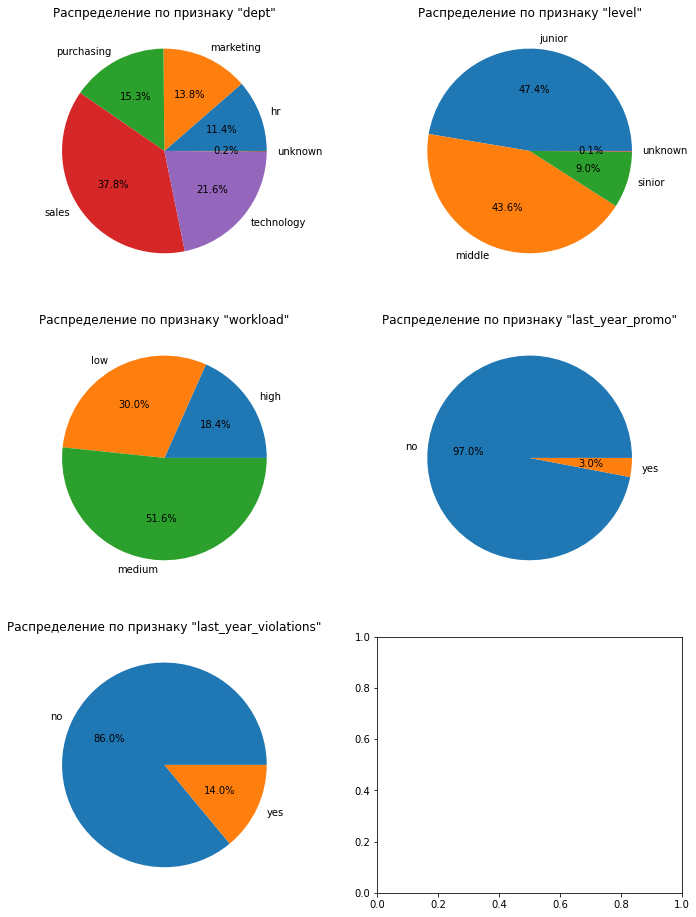

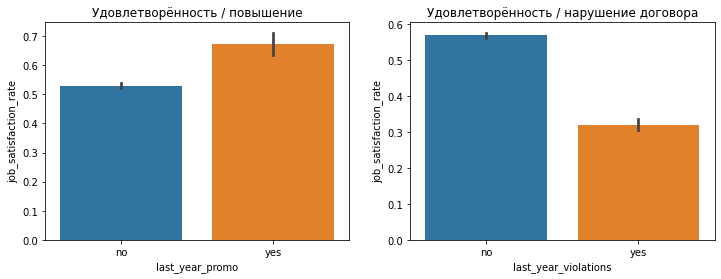

In [ ]:
plt.show()

issl_analiz_cat(train_job_satisfaction_rate, 16)

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.barplot(data=train_job_satisfaction_rate, x='last_year_promo', y='job_satisfaction_rate',
                ax=axes[0]).set(title='Удовлетворённость / повышение')
sns.barplot(data=train_job_satisfaction_rate, x='last_year_violations', y='job_satisfaction_rate',
                ax=axes[1]).set(title='Удовлетворённость / нарушение договора')
plt.show()

Что видно по категориальным признакам:

- сотрудники, которых в последний год повысили, более удовлетворены работой (логично, но повысили только 3% людей);
- сотрудники, которые в последний год нарушили трудовой договор, менее удовлетворены работой (тоже логично, нарушителей 14%, интересно, это нарушение следствие неудовлетворённости или неудовлетворённость следствие наказания за нарушение);
- большинство сотрудников работают в продажах или технологическом отделе, на должности junior или middle, средне загружены работой;
- по диаграммам рассеяния выше видна прямая зависимость удовлетворённости от оценки руководителя (при этом по отделам, должностям, загрузке особо не отличается), а от зарплаты - только при самой высокой зарплате в технологическом отделе, у синьоров, с высокой загрузкой (от отдела на маленьких и средних зарплатах не зависит); также видно, что зарплата растёт вместе с должностью и загруженностью (а на удовлетворённость влияет только очень высокая зарплата).

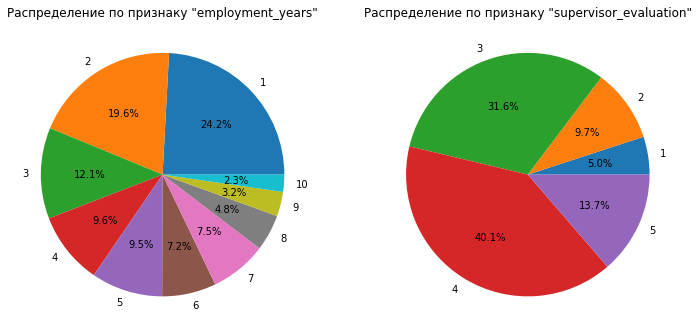

In [ ]:
issl_analiz_cat(train_job_satisfaction_rate, 6, ['employment_years', 'supervisor_evaluation'])

Что видно по дискретным признакам:

- больше половины сотрудников работают в компании 1-3 года, больше 7 лет совсем мало людей (чем больше отработанных лет, тем меньше таких сотрудников);
- работа большинства сотрудников оценена руководством на 4 (40.1%), чуть меньше на 3 (31,6%); 13,7% оценка 5, на 1 оценены 5% и на 2 9,7% сотрудников.

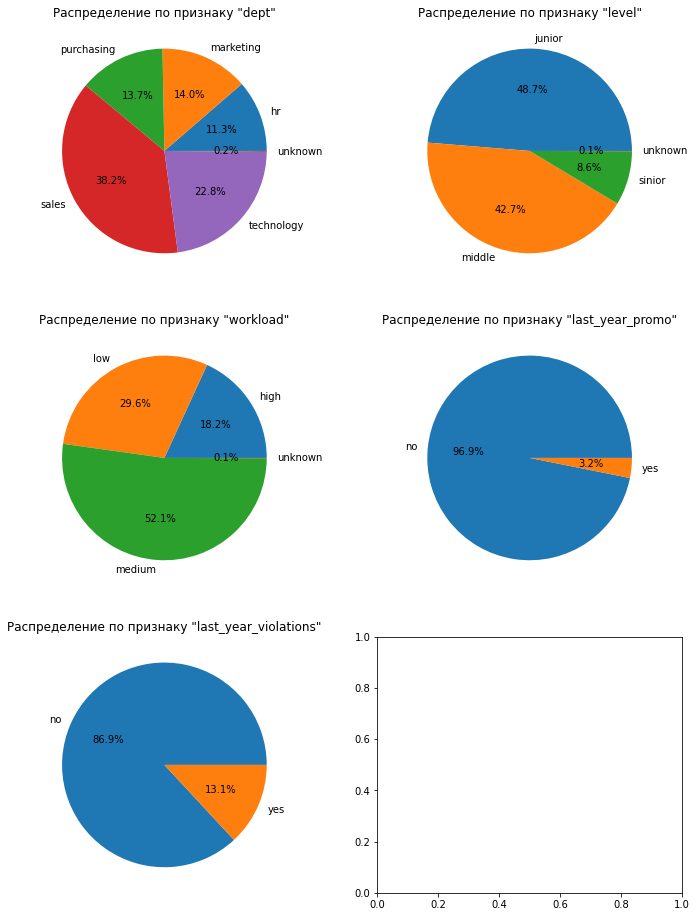

In [ ]:
issl_analiz_cat(test_features, 16)

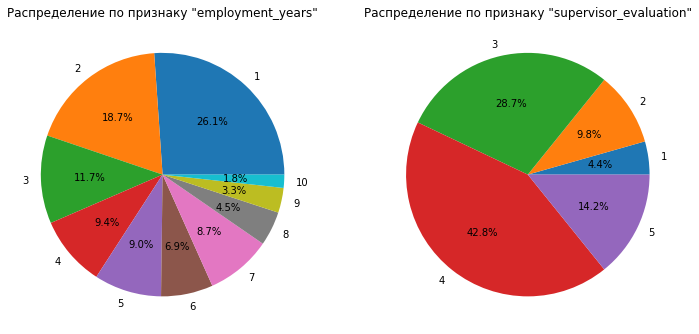

In [ ]:
issl_analiz_cat(test_features, 6, ['employment_years', 'supervisor_evaluation'])

На тестовой выборке практически такое же распределение категориальных признаков, как и на тренировочной (разница до 3%).

Тренировочная выборка:


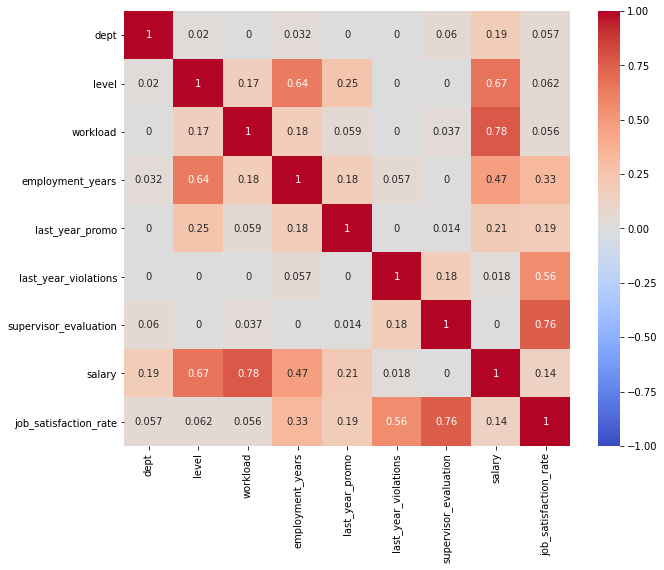

In [ ]:
interval_cols = ['salary', 'job_satisfaction_rate']

print('Тренировочная выборка:')
plt.figure(figsize = (10,8))
sns.heatmap(train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True,
            cmap='coolwarm', vmin=-1)
plt.show()

Тестовая выборка:


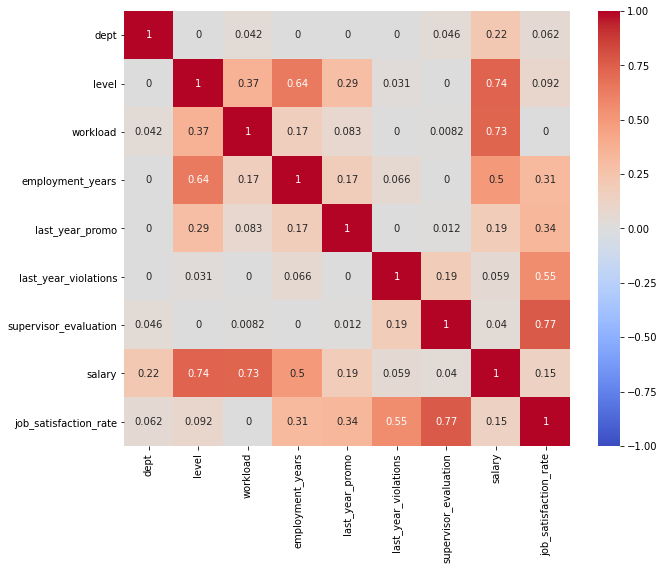

In [ ]:
print('Тестовая выборка:')
plt.figure(figsize = (10,8))
sns.heatmap(test_features.merge(test_target_job_satisfaction_rate, on='id', how='left').drop('id', axis=1).phik_matrix(
    interval_cols=interval_cols), annot=True, cmap='coolwarm', vmin=-1)
plt.show()

Мультиколлинеарности нет между признаками, есть высокая зависимость между:
- зарплатой и загруженностью,
- оценкой работы сотрудника руководителем и удовлетворённостью сотрудника.

Зависимость между зарплатой и должностью на тренировочной выборке средняя (0.67), на тестовой высокая (0.74).

Средняя зависимость между отработанными годами и должностью, нарушением договора и удовлетворённостью.

### Подготовка  данных

- подготовку признаков выполнить в пайплайне, дополнив пайплайн шага предобработки;
- при кодировании учитывать особенности признаков и моделей;
- использовать как минимум два кодировщика.

In [ ]:
num_col = train_job_satisfaction_rate.select_dtypes(exclude='object').drop(['id', 'job_satisfaction_rate'], axis=1).columns
cat_col = train_job_satisfaction_rate.select_dtypes(include='object').columns
ohe_col = ['last_year_violations', 'last_year_promo', 'dept']

print('Количественные признаки:', num_col.tolist())
print('Признаки для OneHotEncoder:', ohe_col)
print('Признаки для OrdinalEncoder:', cat_col.drop(ohe_col).tolist())

Количественные признаки: ['employment_years', 'supervisor_evaluation', 'salary']
Признаки для OneHotEncoder: ['last_year_violations', 'last_year_promo', 'dept']
Признаки для OrdinalEncoder: ['level', 'workload']


In [ ]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
        ('ord', OrdinalEncoder(categories=[
                    ['junior', 'middle', 'sinior', 'unknown'],
                    ['low', 'medium', 'high', 'unknown']],
            handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1))
    ]
)

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_col.drop(ohe_col)),
        ('ohe', ohe_pipe, ohe_col),
        ('num', StandardScaler(), num_col)
    ],
    remainder='passthrough') # verbose_feature_names_out=False)

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['junior',
                                                                              'middle',
                                                                              'sinior',
                                                                              'unknown'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high',
                                                                              'unknown']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_o...
                                 Index(['level', 'workload'], dtype='object')),
                                ('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['last_year_violations', 'last_year_promo',
                                  'dept']),
                                ('num', StandardScaler(),
                                 Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object'))])

### Обучение моделей

- обучить как минимум две модели (линейную модель и дерево решений);
- подобрать гиперпараметры как минимум для одной модели с помощью одного из известных инструментов;
- выбрать лучшую модель и проверить её качество (на основе новой метрики — SMAPE).

In [ ]:
def smape(y_true, y_pred):
    if (len(y_true)==len(y_pred)):
        return 100 / len(y_true) * np.sum( np.abs(y_true - y_pred) / ( (np.abs(y_true) + np.abs(y_pred) ) / 2 ) )

    #summa = 0
    #for i in range(len(y_true)):
    #    summa += np.abs(y_true[i]-y_pred[i]) / ( ( np.abs(y_true[i]) + np.abs(y_pred[i]) ) / 2)
    #return summa * 100 / len(y_true)

scorer_smape = make_scorer(smape, greater_is_better=False)

In [ ]:
RANDOM_STATE = 42

Xy_train = train_job_satisfaction_rate.drop('id', axis=1).drop_duplicates().reset_index(drop=True)

X_train = Xy_train.drop('job_satisfaction_rate', axis=1)
X_train.shape

(3755, 8)

In [ ]:
y_train = Xy_train['job_satisfaction_rate']
test_xy = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')

In [ ]:
X_test = test_xy.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_xy['job_satisfaction_rate']

In [ ]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,11),
        'models__min_samples_split': range(2,11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring=scorer_smape,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print('Метрика SMAPE для лучшей модели на кросс-валидации:', -grid.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior',
                                                                                               'unknown'],
                    

In [ ]:
print('Результаты всех моделей на кросс-валидации:')

pd.DataFrame(grid.cv_results_)[['rank_test_score', 'mean_test_score', 'param_models', 'param_models__max_depth',
                'param_models__min_samples_split', 'param_preprocessor__num']].sort_values(by='rank_test_score') #.head(10)

Результаты всех моделей на кросс-валидации:


,rank_test_score,mean_test_score,param_models,param_models__max_depth,param_models__min_samples_split,param_preprocessor__num
228,1,-16.046098,DecisionTreeRegressor(random_state=42),10,6,StandardScaler()
230,2,-16.057078,DecisionTreeRegressor(random_state=42),10,6,passthrough
229,3,-16.064698,DecisionTreeRegressor(random_state=42),10,6,MinMaxScaler()
225,4,-16.104010,DecisionTreeRegressor(random_state=42),10,5,StandardScaler()
227,5,-16.109056,DecisionTreeRegressor(random_state=42),10,5,passthrough
...,...,...,...,...,...,...
25,217,-23.965105,DecisionTreeRegressor(random_state=42),2,10,MinMaxScaler()
14,217,-23.965105,DecisionTreeRegressor(random_state=42),2,6,passthrough
245,244,-25.191316,LinearRegression(),NaN,NaN,passthrough
244,245,-25.191316,LinearRegression(),NaN,NaN,MinMaxScaler()


In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
print('Метрика SMAPE от лучшей модели на тестовой выборке:', round(smape(y_test, y_pred), 4))

Метрика SMAPE от лучшей модели на тестовой выборке: 14.8381


На тестовой выборке модель-победитель из пайплайна DecisionTreeRegressor с гиперпараметрами max_depth=10, min_samples_split=6 выдаёт SMAPE = 14.8381 (это меньше 15, критерий успеха выполнен)!

### Оформление выводов

**Промежуточный вывод задачи 1:** модель DecisionTreeRegressor при min_samples_split=6 и max_depth=10 даёт SMAPE<15 (14.8381).

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

- Тренировочная выборка: `train_quit.csv`
- Входные признаки тестовой выборки, как в задаче 1: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_quit.csv`

In [ ]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    train_quit = pd.read_csv('C:/Users/Student/Desktop/train_quit.csv')
    test_target_quit = pd.read_csv('C:/Users/Student/Desktop/test_target_quit.csv')

In [ ]:
dfinfo(train_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [ ]:
dfinfo(test_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
dfinfo(test_target_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


В тренировочной выборке 4000 строк, пропусков нет. В целевом признаке тестовой выборки 2000 строк, пропусков нет. Во входных признаках тестовой выборки (2000 строк) мы заполнили пропуски в задаче 1. В тестовой выборке, как и в задаче 1, входные и целевой в разном порядке, надо будет присоединять по id и заново делить.

### Предобработка  данных

In [ ]:
predobr(train_quit)

Пропуски:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
Дубликатов 0
Уникальные значения "dept": ['hr' 'marketing' 'purchasing' 'sales' 'technology']
Уникальные значения "level": ['junior' 'middle' 'sinior']
Уникальные значения "workload": ['high' 'low' 'medium']
Уникальные значения "last_year_promo": ['no' 'yes']
Уникальные значения "last_year_violations": ['no' 'yes']
Уникальные значения "quit": ['no' 'yes']


In [ ]:
predobr(test_features)

Пропуски:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Дубликатов 0
Уникальные значения "dept": ['hr' 'marketing' 'purchasing' 'sales' 'technology' 'unknown']
Уникальные значения "level": ['junior' 'middle' 'sinior' 'unknown']
Уникальные значения "workload": ['high' 'low' 'medium' 'unknown']
Уникальные значения "last_year_promo": ['no' 'yes']
Уникальные значения "last_year_violations": ['no' 'yes']


In [ ]:
predobr(test_target_quit)

Пропуски:
id      0
quit    0
dtype: int64
Дубликатов 0
Уникальные значения "quit": ['no' 'yes']


В новых выборках явных и неявных дубликатов нет, замена пропусков не понадобилась.

### Исследовательский анализ  данных

#### Графики, диаграммы

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Сравним распределение количественных признаков 
в тренировочной и тестовой выборках:


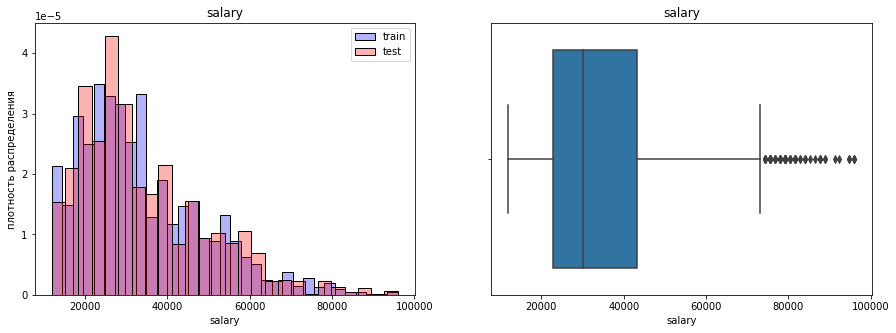

In [ ]:
issl_analiz2(train_quit.drop('id', axis=1), test_features.merge(test_target_quit, on='id',
                                how='left').drop('id', axis=1), 5, ['salary'])

Распределение в тренировочной и тестовой выборках очень похожее (как и в задаче 1):

- зарплата - "многопиковое" нормальное распределение с большим правым хвостом (большая зарплата у единиц, что логично).

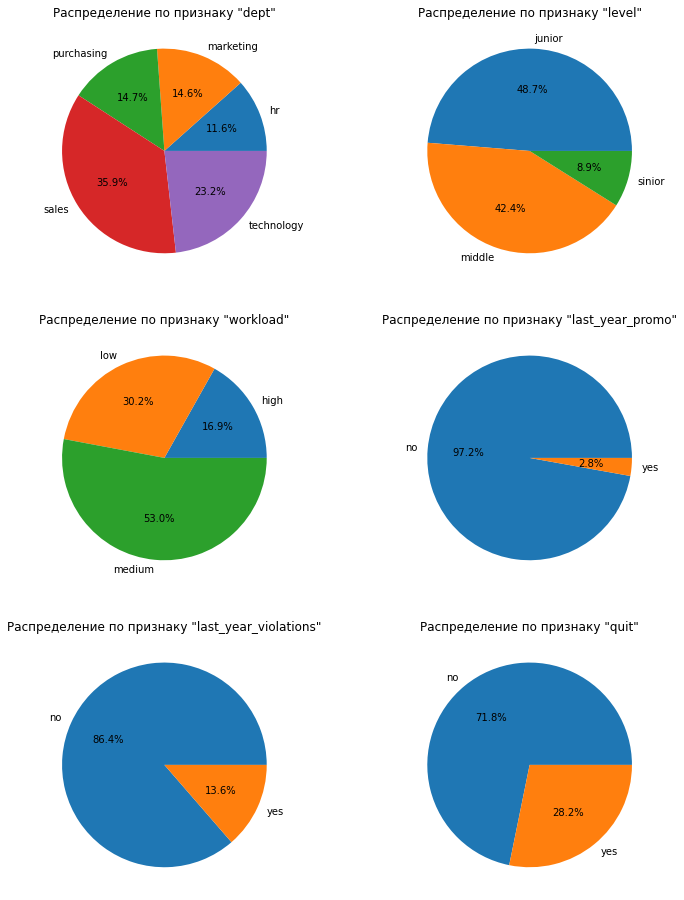

In [ ]:
issl_analiz_cat(train_quit, 16)

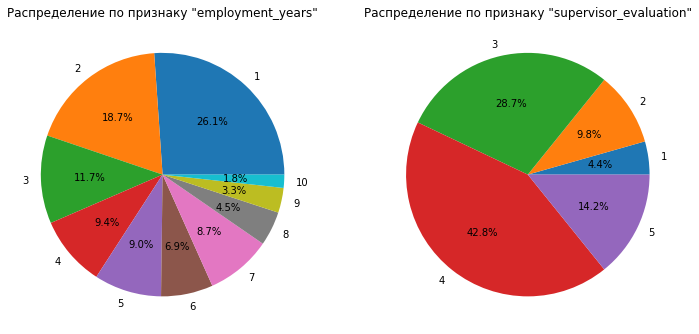

In [ ]:
issl_analiz_cat(test_features.merge(test_target_quit, on='id', how='left'), 6,
                ['employment_years', 'supervisor_evaluation'])

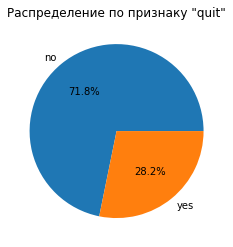

In [ ]:
test_target_quit.pivot_table(index='quit', aggfunc='count').plot(kind='pie', y='id', autopct='%1.1f%%',
                    legend=False, xlabel='quit', ylabel='', title=f'Распределение по признаку "quit"');

Распределение сотрудников по категориальным и дискретным признакам тоже не особо отличается от выборки из задачи 1. По новому признаку (факт увольнения) распределение на тренировочной и тестовой выборках одинаковое.

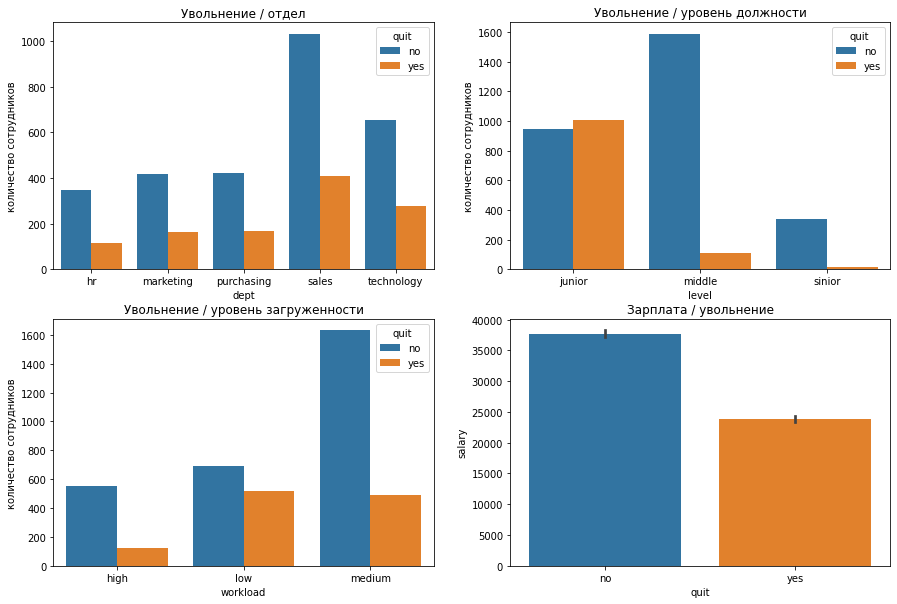

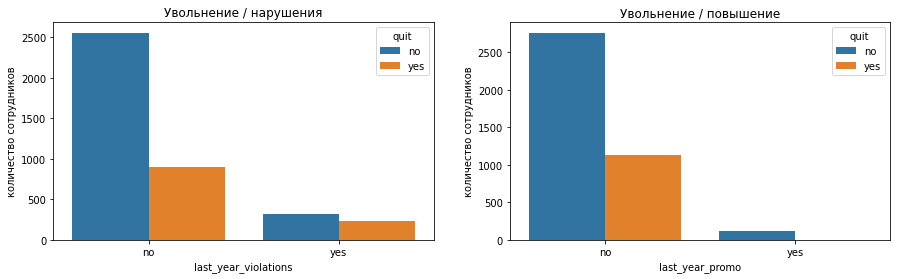

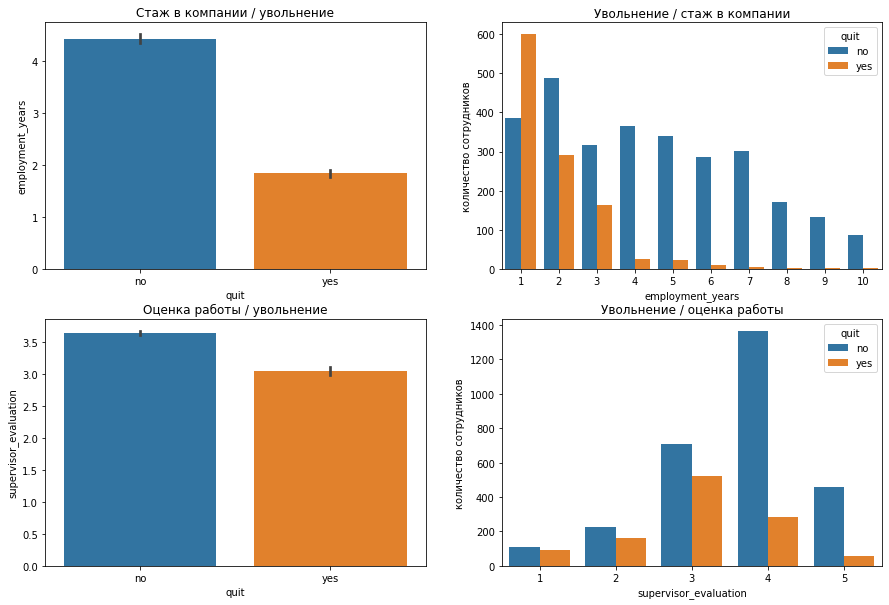

In [ ]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.barplot(data=train_quit.pivot_table(index=['dept','quit'], aggfunc='count').reset_index(), x='dept', y='id', hue='quit',
                ax=axes[0][0]).set(title='Увольнение / отдел', ylabel='количество сотрудников')
sns.barplot(data=train_quit.pivot_table(index=['level','quit'], aggfunc='count').reset_index(), x='level', y='id',
            hue='quit', ax=axes[0][1]).set(title='Увольнение / уровень должности', ylabel='количество сотрудников')
sns.barplot(data=train_quit.pivot_table(index=['workload','quit'], aggfunc='count').reset_index(), x='workload', y='id',
            hue='quit', ax=axes[1][0]).set(title='Увольнение / уровень загруженности', ylabel='количество сотрудников')
sns.barplot(data=train_quit, x='quit', y='salary', ax=axes[1][1]).set(title='Зарплата / увольнение')

plt.show()

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.barplot(data=train_quit.pivot_table(index=['last_year_violations','quit'], aggfunc='count').reset_index(), hue='quit',
    x='last_year_violations', y='id', ax=axes[0]).set(title='Увольнение / нарушения', ylabel='количество сотрудников')
sns.barplot(data=train_quit.pivot_table(index=['last_year_promo','quit'], aggfunc='count').reset_index(), hue='quit',
            x='last_year_promo', y='id', ax=axes[1]).set(title='Увольнение / повышение', ylabel='количество сотрудников')

plt.show()

fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.barplot(data=train_quit, x='quit', y='employment_years', ax=axes[0][0]).set(title='Стаж в компании / увольнение')
sns.barplot(data=train_quit.pivot_table(index=['employment_years','quit'], aggfunc='count').reset_index(), hue='quit',
    x='employment_years', y='id', ax=axes[0][1]).set(title='Увольнение / стаж в компании', ylabel='количество сотрудников')

sns.barplot(data=train_quit, x='quit', y='supervisor_evaluation', ax=axes[1][0]).set(title='Оценка работы / увольнение')
sns.barplot(data=train_quit.pivot_table(index=['supervisor_evaluation','quit'], aggfunc='count').reset_index(), hue='quit',
    x='supervisor_evaluation', y='id', ax=axes[1][1]).set(title='Увольнение / оценка работы', ylabel='количество сотрудников')

plt.show()

Что видно по столбчатым диаграммам:

- сотрудники, которых в последний год повысили, не увольнялись, из неповышенных уволилась примерно треть;
- чаще увольняются сотрудники с низкой загруженностью; джуниоры; отработавшие в компании менее 2 лет (отработавшие больше 7 лет вообще почти не увольняются); с зарплатой ниже 25000;
- среди нарушивших трудовой договор доля увольняющихся выше;
- доля уволившихся не зависит от отдела (везде около трети увольняются);
- средняя оценка уволившихся незначительно ниже, но доля уволенных высокая с оценками 1-3 и намного ниже с оценками 4-5.

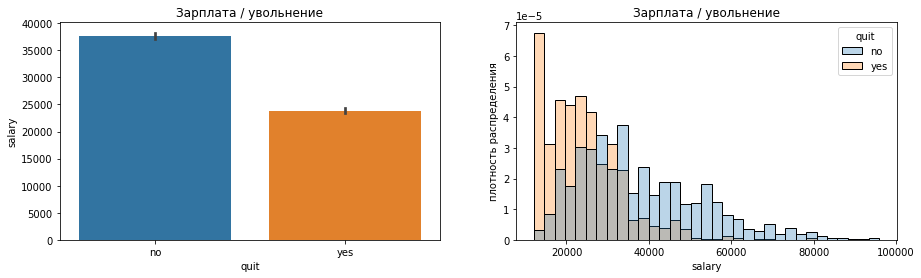

In [ ]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.barplot(data=train_quit, x='quit', y='salary', ax=axes[0]).set(title='Зарплата / увольнение');
sns.histplot(stat='density', common_norm=False, data=train_quit, x='salary', ax=axes[1], alpha=0.3,
             hue='quit').set(title='Зарплата / увольнение', ylabel='плотность распределения');

Уволилось много народу с зарплатой ниже 20 тыс., а больше 50 тыс. почти никто не уволился.

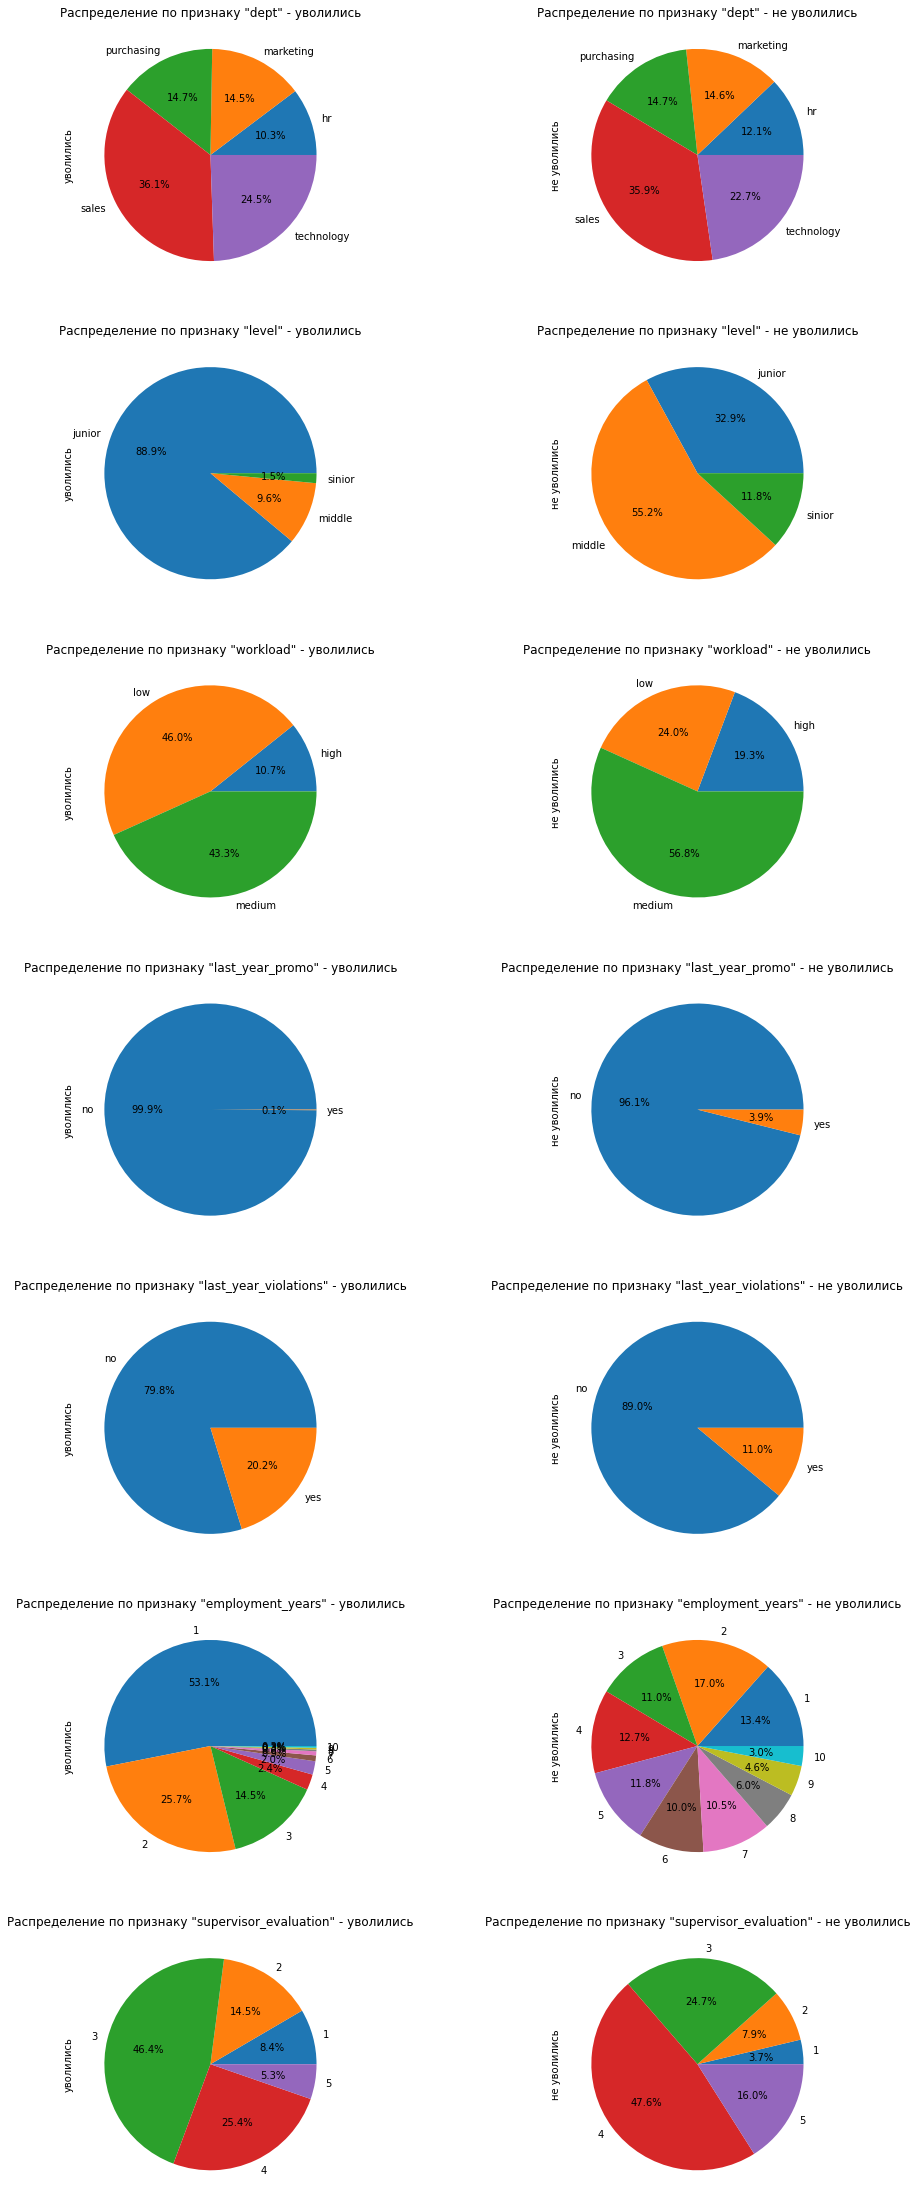

In [ ]:
list_cat_discr = train_quit.select_dtypes(include='object').columns.drop('quit').tolist() + ['employment_years',
                                                                                             'supervisor_evaluation']
i=0
fig,axes = plt.subplots(nrows=len(list_cat_discr), ncols=2, figsize=(16, 40))
for col in list_cat_discr:
    train_quit.query('quit=="yes"').pivot_table(index=col, aggfunc='count').plot(kind='pie', y='id', ax=axes[i][0],
                    autopct='%1.1f%%', legend=False, xlabel=col, ylabel='уволились',
                    title=f'Распределение по признаку "{col}" - уволились')
    train_quit.query('quit=="no"').pivot_table(index=col, aggfunc='count').plot(kind='pie', y='id', ax=axes[i][1],
                    autopct='%1.1f%%', legend=False, xlabel=col, ylabel='не уволились',
                    title=f'Распределение по признаку "{col}" - не уволились')
    i+=1

Нарисовали круговые диаграммы отдельно для уволившихся и оставшихся, чтоб сравнить процентное соотношение:

- от отдела увольнения не зависят,
- среди уволившихся почти одни джуниоры,
- доля уволившихся с низкой загруженностью почти в 2 раза выше, чем оставшихся, а с высокой и средней такой большой разницы нет,
- из тех, кого повысили, уволились буквально единицы,
- среди уволившихся доля нарушивших трудовой договор почти в 2 раза больше, чем среди оставшихся,
- отработавшие в компании больше 3 лет практически не увольнялись,
- среди уволившихся преобладает оценка их работы 3, среди оставшихся 4,

что подтверждает то, что видно и на других типах графиков.

#### Портрет «уволившегося сотрудника»

С наибольшей вероятностью он:

- работал в продажах (потому что там вообще больше сотрудников, поэтому и количество уволившихся больше, а доля примерно одинакова в любом отделе),
- получал зарплату до 20000, работал джуниором, был не очень загружен работой,
- отработал в компании 1 год, в последний год его не повышали, возможно нарушал трудовой договор,
- его работа оценивалась руководством ниже, чем оставшихся коллег (около 3-3.5).

#### Сравним распределение признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников (из тестовой выборки)

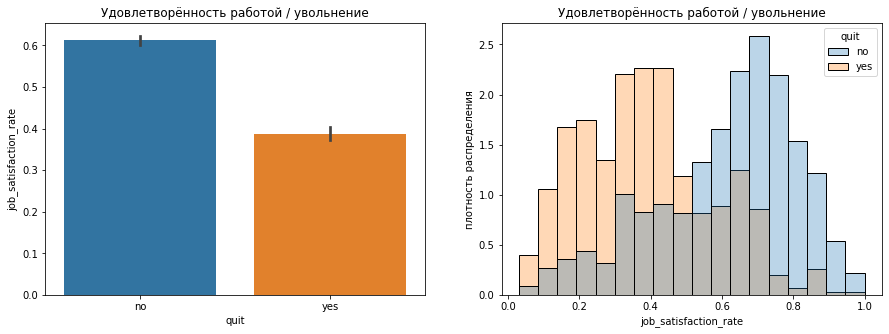

In [ ]:
test_features_new = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left').merge(test_target_quit,
                                                                                     on='id', how='left')


fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.barplot(data=test_features_new, x='quit', y='job_satisfaction_rate', ax=axes[0]).set(
    title='Удовлетворённость работой / увольнение')

sns.histplot(stat='density', common_norm=False, data=test_features_new, x='job_satisfaction_rate', ax=axes[1], alpha=0.3,
             hue='quit').set(title='Удовлетворённость работой / увольнение', ylabel='плотность распределения')

plt.show()

Средняя удовлетворённость работой действительно ниже у тех, кто уволился, примерно в 1,5 раза. Распределение на нормированной гистограмме это подтверждает. Среди уволившихся очень мало довольных работой (хотя встречаются и довольные на 0.8 и выше, но очень мало), среди оставшихся мало недовольных (относительно общего количества оставшихся).

Применим статистический тест:

- нулевая гипотеза: нет разницы в удовлетворённости работой между теми, кто уволился, и остальными;
- альтернативная гипотеза: уволившиеся менее довольны работой, чем оставшиеся.

In [ ]:
results = st.ttest_ind(test_features_new.query('quit=="yes"')['job_satisfaction_rate'],
                       test_features_new.query('quit=="no"')['job_satisfaction_rate'], equal_var=False, alternative='less')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < 0.01:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.3854314015771867e-101
Отвергаем нулевую гипотезу


Альтернативная гипотеза подтвердилась (уволившиеся менее довольны работой, чем оставшиеся).

### Добавление нового входного признака

In [ ]:
train_quit['job_satisfaction_rate'] = grid.best_estimator_.predict(train_quit.drop('quit', axis=1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.602105
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.837297
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.402143
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.334444
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.813636


In [ ]:
test_features_new['job_satisfaction_rate'] = grid.best_estimator_.predict(test_features)
test_features_new.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.837297,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.657826,no
2,467458,sales,middle,low,5,no,no,4,19200,0.664000,no
3,418655,sales,middle,low,6,no,no,4,19200,0.664000,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.807978,no


### Подготовка  данных

- подготовку признаков выполнить в пайплайне, дополнив пайплайн предобработки;
- при кодировании учитывать особенности признаков и моделей;
- использовать как минимум два кодировщика.

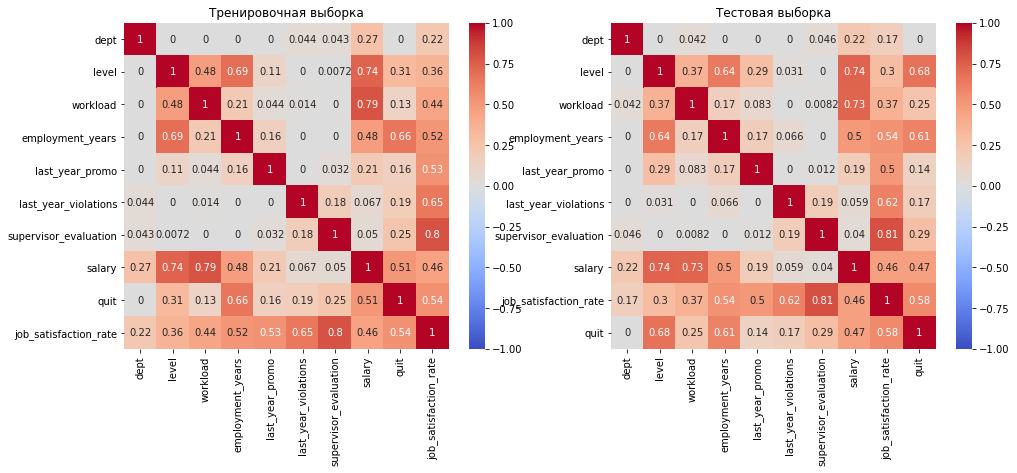

In [ ]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.heatmap(train_quit.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', vmin=-1,
            ax=axes[0]).set(title='Тренировочная выборка')
sns.heatmap(test_features_new.drop('id', axis=1).phik_matrix(interval_cols=interval_cols),
            annot=True, cmap='coolwarm', vmin=-1, ax=axes[1]).set(title='Тестовая выборка')
plt.show()

Проверили признаки на наличие мультиколлинеарности, её нет (корреляции примерно такие же, как в задаче 1), у нового признака "уволился или нет" средняя зависимость с удовлетворённостью работой и стажем в компании (на тренировочной ещё с зарплатой, а на тестовой с должностью).

In [ ]:
num_col = train_quit.select_dtypes(exclude='object').drop('id', axis=1).columns
#cat_col = train_quit.select_dtypes(include='object').drop('quit', axis=1).columns

print('Количественные признаки:', num_col.tolist())
print('Признаки для OHE:', ohe_col)
print('Признаки для OrdinalEncoder:', cat_col.drop(ohe_col).tolist())


Xy_train = train_quit.drop('id', axis=1).drop_duplicates().reset_index(drop=True)
X_train = Xy_train.drop('quit', axis=1)
y_train = Xy_train['quit']

X_test = test_features_new.drop(['id', 'quit'], axis=1)
y_test = test_features_new['quit']

data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_col.drop(ohe_col)),
        ('ohe', ohe_pipe, ohe_col),
        ('num', StandardScaler(), num_col)
    ],
    remainder='passthrough')

#pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=data_preprocessor.get_feature_names_out())

Количественные признаки: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
Признаки для OHE: ['last_year_violations', 'last_year_promo', 'dept']
Признаки для OrdinalEncoder: ['level', 'workload']


Используем data_preprocessor из задачи 1, в нём 2 кодировщика для категориальных бинарных и мультиклассовых (в т.ч. ранговых) признаков.

### Обучение модели

- обучить как минимум три модели,
- как минимум для двух из них подобрать гиперпараметры,
- проверить качество лучшей модели на метрике ROC-AUC (критерий успеха: ROC-AUC ≥0.91 на тестовой выборке).

In [ ]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,6),
        #'models__min_samples_split': range(2,15),
        'models__min_samples_leaf': range(2,12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)], #solver='liblinear')],
        'models__C': [0.1,0.4,0.6,0.8,1,2,5,10],
        #'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print('Метрика ROC-AUC для лучшей модели на на кросс-валидации:', round(grid.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior',
                                                                                               'unknown'],
                    

Из 3 моделей (для всех перебирались гиперпараметры):
- DecisionTreeClassifier
- LogisticRegression
- KNeighborsClassifier

победила DecisionTreeClassifier с гиперпараметрами max_depth=4, min_samples_leaf=11 с ROC-AUC на кросс-валидации 0.9029.

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
preds = grid.best_estimator_.predict_proba(X_test)
print('ROC-AUC на тестовой выборке:', round(roc_auc_score(y_test, preds[:,1]), 4))

ROC-AUC на тестовой выборке: 0.9101


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
for col in X_train.select_dtypes(include='object').columns:
    print(X_train[col].sort_values().unique())
    print(X_test[col].sort_values().unique())

['hr' 'marketing' 'purchasing' 'sales' 'technology']
['hr' 'marketing' 'purchasing' 'sales' 'technology' 'unknown']
['junior' 'middle' 'sinior']
['junior' 'middle' 'sinior' 'unknown']
['high' 'low' 'medium']
['high' 'low' 'medium' 'unknown']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']


На тестовой выборке ROC-AUC лучшей модели 0.9101 > 0.91, критерий успеха выполняется.

In [ ]:
#from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
#dummy_clf.predict(X_test)
#dummy_clf.score(X_test, y_test)
roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:,1])

0.5

**Промежуточный вывод задачи 2:** модель DecisionTreeClassifier при max_depth=4, min_samples_leaf=11 (выбранная автоматически в пайплайне) даёт ROC-AUC 0.9101 на тестовой выборке, критерий успеха выполняется.

# Общий вывод

**Задача** - построить 2 модели:

- которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика (задача 1),
- которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании (задача 2),
- предложить способы избежать внезапных увольнений сотрудников.


**Этапы работы - задача 1**:

- **предобработка** - явных и неявных дубликатов не обнаружили, пропуски (всего 13 штук на общие 6000 строк) в названии отдела и уровня должности заполнили в пайплайне значением "unknown", им же заменили по 1 найденному пробелу в тестовой выборке в названии отдела и уровне загруженности;

- **исследовательский анализ** - аномалий и выбросов не обнаружили, на графиках признаки в тренировочной и тестовой выборках распределены одинаково, мультиколлинеарности между признаками нет;

- **подготовку признаков** провели в пайплайне, который заполняет пропуски и кодирует категориальные признаки 2 кодировщиками;

- **обучили 2 модели** в пайплайне с перебором гиперпараметров, лучшая модель из пайплайна показала достаточное качество на метрике SMAPE на тестовой выборке (14.8381 < 15).

**Этапы работы - задача 2**:

- **предобработка** - явных и неявных дубликатов, пропусков нет;

- **исследовательский анализ** - аномалий и выбросов не обнаружили, на графиках признаки в тренировочной и тестовой выборках распределены одинаково, мультиколлинеарности между признаками нет (заметных отличий от выборки из задачи 1 тоже нет);

- **портрет среднестатистического уволившегося сотрудника** - джуниор с низкой загруженностью (отдел не важен), работает менее 2 лет в компании, не повышался, получает до 20 тыс., трудовой договор не нарушал, оценка его работы руководством средняя;

- **уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник** - подтверждается;

- **подготовку признаков** провели в пайплайне из задачи 1, перед этим добавили к входным признакам новый признак `job_satisfaction_rate`, предсказанный лучшей моделью из задачи 1 (у нового признака тоже нет мультиколлинеарности даже с признаком увольнения);

- **обучили 3 модели** в пайплайне с перебором гиперпараметров, лучшая модель из пайплайна показала достаточное качество на метрике ROC-AUC на тестовой выборке (0.9101 > 0.91).

**Выводы и дополнительные предложения для бизнеса**:

Чаще всего увольняются джуниоры, проработавшие менее 2 лет и с низкой загруженностью. При этом джуниоров в компании почти половина. Скорее всего, текучка кадров среди начинающих вызвана их слабой заинтересованностью и отсутствием роста. Возможно, это молодёжь "ищет себя", меняя места работы и не успевая там чего-то добиться. А может, джуниор хочет выполнять более важную работу, но ему такую не доверяют, и он не видит перспектив и уходит их искать в другой компании.

Можно предложить обратить внимание на джуниоров, проработавших около года: если среди них есть приносящие компании реальную пользу и/или способные к более сложной (важной, интересной для них) работе, то увеличить таким нагрузку и зарплату, предложить повышение или перевод на более перспективное место. Возможно, есть смысл, чтобы количество джуниоров переходило в качество, а деньги, которые компания зря тратит на обучение "разбегающихся", лучше потратить на зарплату перспективным сотрудникам.